In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt


# Downloads CIFAR-10 automatically and loads it into memory
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
from skimage import io, util

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

Train: (50000, 32, 32, 3) (50000, 1)
Test: (10000, 32, 32, 3) (10000, 1)


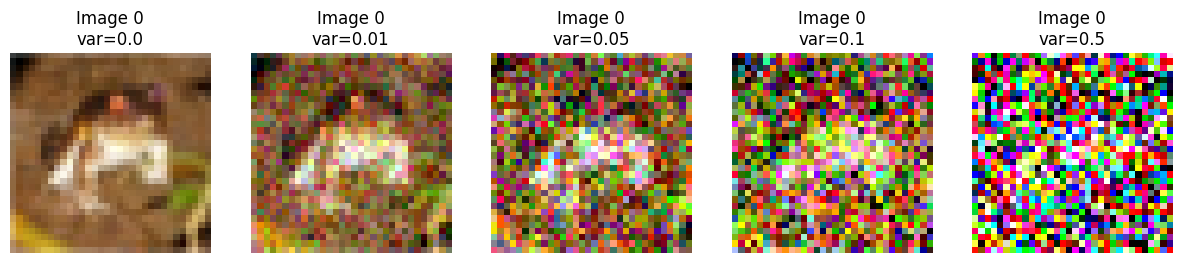

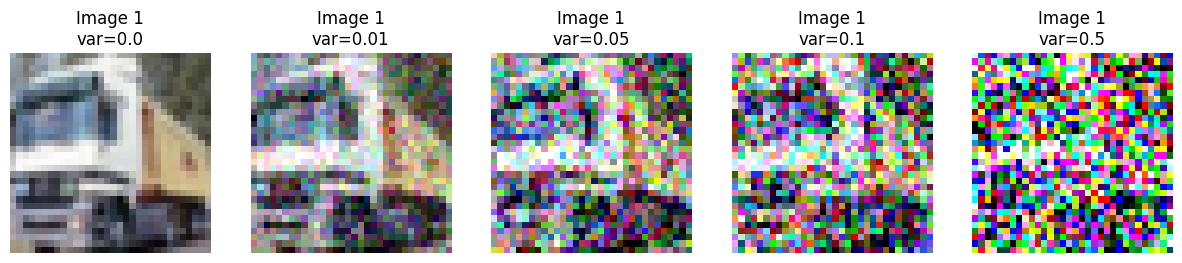

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, util

# Variances for Gaussian noise
variances = [0, 0.01, 0.05, 0.1, 0.5]

# Store results
results = []

for var in variances:
    noisy0 = util.random_noise(x_train[0], mode='gaussian', var=var)
    noisy1 = util.random_noise(x_train[1], mode='gaussian', var=var)
    
    # Save images
    fname0 = f"noisy0_{var}.jpg"
    fname1 = f"noisy1_{var}.jpg"
    io.imsave(fname0, (noisy0 * 255).astype("uint8"))
    io.imsave(fname1, (noisy1 * 255).astype("uint8"))
    
    # Append metadata for DataFrame
    results.append({"Image": "img0", "Variance": var, "Path": fname0, "Array": noisy0})
    results.append({"Image": "img1", "Variance": var, "Path": fname1, "Array": noisy1})

# Convert to DataFrame
df = pd.DataFrame(results)

# Pretty grid visualization
def show_noisy_grid(img_results, title_prefix="Image"):
    fig, axes = plt.subplots(1, len(img_results), figsize=(15, 3))
    for ax, row in zip(axes, img_results):
        ax.imshow(row["Array"])
        ax.set_title(f"{title_prefix}\nvar={row['Variance']}")
        ax.axis("off")
    plt.show()

# Show both grids
show_noisy_grid(df[df["Image"] == "img0"].to_dict("records"), "Image 0")
show_noisy_grid(df[df["Image"] == "img1"].to_dict("records"), "Image 1")


c:\Users\nunni\miniconda3\envs\bachelor\Lib\site-packages\pyiqa\archs\brisque_arch.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sv_coef, sv = torch.load(pretrained_m

  Image  Variance     BRISQUE       PSNR      SSIM
0  img0      0.00   26.015503        inf  1.000000
1  img0      0.01   49.358734  21.834199  0.752903
2  img0      0.05   73.672363  16.302191  0.488896
3  img0      0.10   87.765427  13.845961  0.348527
4  img0      0.50  111.373657  10.744505  0.169091
5  img1      0.00   53.885101        inf  1.000000
6  img1      0.01   43.437073  22.574998  0.900193
7  img1      0.05   66.232605  16.142044  0.688053
8  img1      0.10   50.963531  14.344674  0.591540
9  img1      0.50  113.908211  10.631398  0.295526


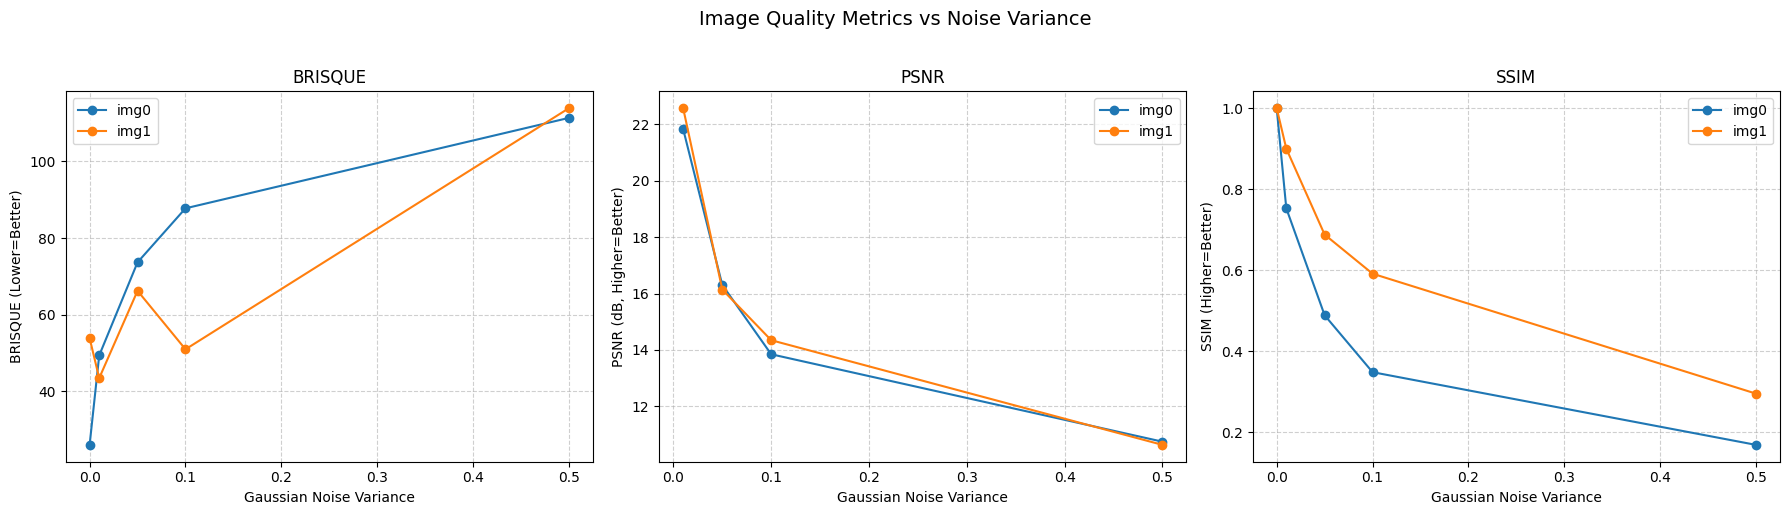

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pyiqa
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Load BRISQUE model
model = pyiqa.create_metric('brisque', device='cpu')

path = 'C:/Users/nunni/OneDrive/Skrivebord/Bachelor/Bachelor/'

# File lists
var = ['noisy0_0.jpg', 'noisy0_0.01.jpg', 'noisy0_0.05.jpg', 'noisy0_0.1.jpg', 'noisy0_0.5.jpg']
var1 = ['noisy1_0.jpg', 'noisy1_0.01.jpg', 'noisy1_0.05.jpg', 'noisy1_0.1.jpg', 'noisy1_0.5.jpg']

# Reference images
ref0 = cv2.cvtColor(cv2.imread(path + var[0]), cv2.COLOR_BGR2RGB)
ref1 = cv2.cvtColor(cv2.imread(path + var1[0]), cv2.COLOR_BGR2RGB)

results = []

def evaluate_set(file_list, ref_img, img_id):
    for fname in file_list:
        noisy = cv2.cvtColor(cv2.imread(path + fname), cv2.COLOR_BGR2RGB)

        # Extract variance from filename
        variance = float(fname.split("_")[-1].replace(".jpg", ""))

        # BRISQUE (via PIL image)
        noisy_pil = Image.fromarray(noisy)
        b_score = model(noisy_pil).item()

        # PSNR
        p_score = psnr(ref_img, noisy, data_range=255)

        # SSIM (multi-channel)
        s_score = ssim(ref_img, noisy, channel_axis=-1, data_range=255)

        results.append({
            "Image": img_id,
            "Variance": variance,
            "BRISQUE": b_score,
            "PSNR": p_score,
            "SSIM": s_score
        })

# Run evaluations
evaluate_set(var, ref0, "img0")
evaluate_set(var1, ref1, "img1")

# DataFrame
df_metrics = pd.DataFrame(results).sort_values(by=["Image", "Variance"])
print(df_metrics)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["BRISQUE", "PSNR", "SSIM"]
ylabels = ["BRISQUE (Lower=Better)", "PSNR (dB, Higher=Better)", "SSIM (Higher=Better)"]

for ax, metric, ylabel in zip(axes, metrics, ylabels):
    for img_id, group in df_metrics.groupby("Image"):
        ax.plot(group["Variance"], group[metric], marker="o", label=img_id)
    ax.set_title(metric)
    ax.set_xlabel("Gaussian Noise Variance")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

plt.suptitle("Image Quality Metrics vs Noise Variance", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("results3.png", dpi=150)
plt.show()


c:\Users\nunni\miniconda3\envs\bachelor\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


  Image  Variance       NIQE       PSNR      SSIM
0  img0      0.00  11.768712        inf  1.000000
1  img0      0.01  10.423682  21.834199  0.752903
2  img0      0.05  13.033840  16.302191  0.488896
3  img0      0.10  14.865434  13.845961  0.348527
4  img0      0.50  18.862613  10.744505  0.169091
5  img1      0.00  13.576314        inf  1.000000
6  img1      0.01  10.747878  22.574998  0.900193
7  img1      0.05  12.643278  16.142044  0.688053
8  img1      0.10  10.875323  14.344674  0.591540
9  img1      0.50  27.905456  10.631398  0.295526


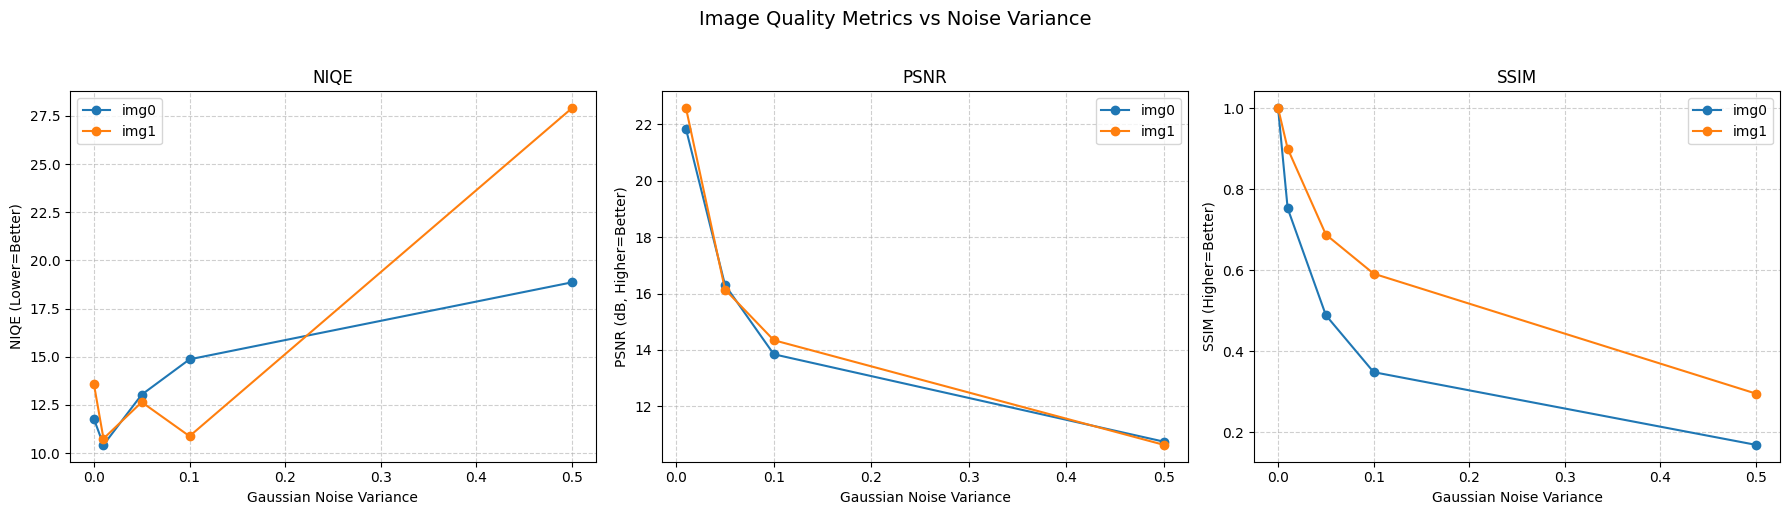

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pyiqa
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from torchvision import transforms

# Load NIQE model
model = pyiqa.create_metric('niqe', device='cpu')

path = 'C:/Users/nunni/OneDrive/Skrivebord/Bachelor/Bachelor/'

# File lists
var = ['noisy0_0.jpg', 'noisy0_0.01.jpg', 'noisy0_0.05.jpg', 'noisy0_0.1.jpg', 'noisy0_0.5.jpg']
var1 = ['noisy1_0.jpg', 'noisy1_0.01.jpg', 'noisy1_0.05.jpg', 'noisy1_0.1.jpg', 'noisy1_0.5.jpg']

# Reference images
ref0 = cv2.cvtColor(cv2.imread(path + var[0]), cv2.COLOR_BGR2RGB)
ref1 = cv2.cvtColor(cv2.imread(path + var1[0]), cv2.COLOR_BGR2RGB)

results = []

resize = transforms.Resize((128, 128))

def evaluate_set(file_list, ref_img, img_id):
    for fname in file_list:
        noisy = cv2.cvtColor(cv2.imread(path + fname), cv2.COLOR_BGR2RGB)

        variance = float(fname.split("_")[-1].replace(".jpg", ""))

        # NIQE (resize -> PIL -> score)
        noisy_pil = Image.fromarray(noisy)
        noisy_resized = resize(noisy_pil)   # upscale to >= 96x96
        n_score = model(noisy_resized).item()

        # PSNR
        p_score = psnr(ref_img, noisy, data_range=255)

        # SSIM
        s_score = ssim(ref_img, noisy, channel_axis=-1, data_range=255)

        results.append({
            "Image": img_id,
            "Variance": variance,
            "NIQE": n_score,
            "PSNR": p_score,
            "SSIM": s_score
        })


# Run evaluations
evaluate_set(var, ref0, "img0")
evaluate_set(var1, ref1, "img1")

# DataFrame
df_metrics = pd.DataFrame(results).sort_values(by=["Image", "Variance"])
print(df_metrics)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["NIQE", "PSNR", "SSIM"]
ylabels = ["NIQE (Lower=Better)", "PSNR (dB, Higher=Better)", "SSIM (Higher=Better)"]

for ax, metric, ylabel in zip(axes, metrics, ylabels):
    for img_id, group in df_metrics.groupby("Image"):
        ax.plot(group["Variance"], group[metric], marker="o", label=img_id)
    ax.set_title(metric)
    ax.set_xlabel("Gaussian Noise Variance")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

plt.suptitle("Image Quality Metrics vs Noise Variance", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("results.png", dpi=150)
plt.show()



c:\Users\nunni\miniconda3\envs\bachelor\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


  Image  Variance      ILNIQE       PSNR      SSIM
0  img0      0.00  122.216510        inf  1.000000
1  img0      0.01  123.051702  21.834199  0.752903
2  img0      0.05  120.950428  16.302191  0.488896
3  img0      0.10  117.561708  13.845961  0.348527
4  img0      0.50  123.421095  10.744505  0.169091
5  img1      0.00  114.713735        inf  1.000000
6  img1      0.01  113.216802  22.574998  0.900193
7  img1      0.05  120.635310  16.142044  0.688053
8  img1      0.10  113.306831  14.344674  0.591540
9  img1      0.50  116.567092  10.631398  0.295526


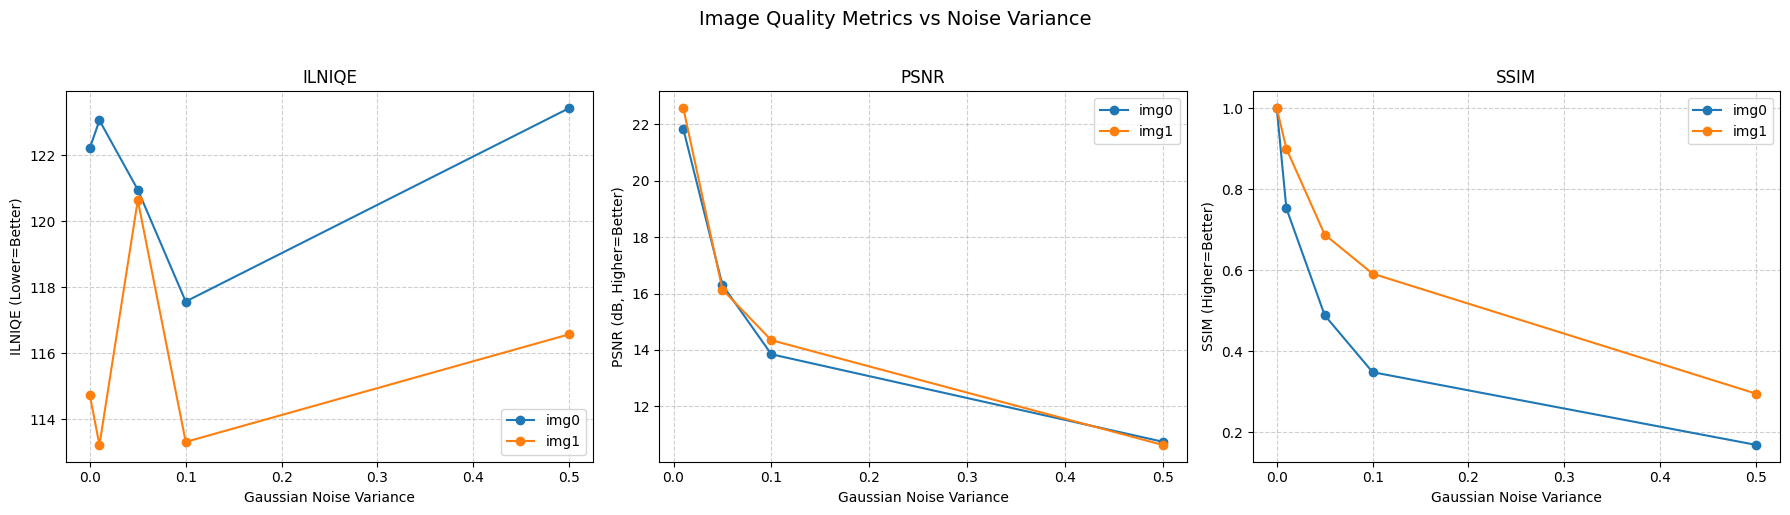

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pyiqa
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from torchvision import transforms

# Load NIQE model
ilniqe_model = pyiqa.create_metric('ilniqe', device='cpu')

path = 'C:/Users/nunni/OneDrive/Skrivebord/Bachelor/Bachelor/'

# File lists
var = ['noisy0_0.jpg', 'noisy0_0.01.jpg', 'noisy0_0.05.jpg', 'noisy0_0.1.jpg', 'noisy0_0.5.jpg']
var1 = ['noisy1_0.jpg', 'noisy1_0.01.jpg', 'noisy1_0.05.jpg', 'noisy1_0.1.jpg', 'noisy1_0.5.jpg']

# Reference images
ref0 = cv2.cvtColor(cv2.imread(path + var[0]), cv2.COLOR_BGR2RGB)
ref1 = cv2.cvtColor(cv2.imread(path + var1[0]), cv2.COLOR_BGR2RGB)

results = []

resize = transforms.Resize((128, 128))

def evaluate_set(file_list, ref_img, img_id):
    for fname in file_list:
        noisy = cv2.cvtColor(cv2.imread(path + fname), cv2.COLOR_BGR2RGB)

        variance = float(fname.split("_")[-1].replace(".jpg", ""))

        # NIQE (resize -> PIL -> score)
        noisy_pil = Image.fromarray(noisy)
        noisy_resized = resize(noisy_pil)   # upscale to >= 96x96
        in_score = model(noisy_resized).item()

        # PSNR
        p_score = psnr(ref_img, noisy, data_range=255)

        # SSIM
        s_score = ssim(ref_img, noisy, channel_axis=-1, data_range=255)

        results.append({
            "Image": img_id,
            "Variance": variance,
            "ILNIQE": in_score,
            "PSNR": p_score,
            "SSIM": s_score
        })


# Run evaluations
evaluate_set(var, ref0, "img0")
evaluate_set(var1, ref1, "img1")

# DataFrame
df_metrics = pd.DataFrame(results).sort_values(by=["Image", "Variance"])
print(df_metrics)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["ILNIQE", "PSNR", "SSIM"]
ylabels = ["ILNIQE (Lower=Better)", "PSNR (dB, Higher=Better)", "SSIM (Higher=Better)"]

for ax, metric, ylabel in zip(axes, metrics, ylabels):
    for img_id, group in df_metrics.groupby("Image"):
        ax.plot(group["Variance"], group[metric], marker="o", label=img_id)
    ax.set_title(metric)
    ax.set_xlabel("Gaussian Noise Variance")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

plt.suptitle("Image Quality Metrics vs Noise Variance", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("results.png", dpi=150)
plt.show()



Loading pretrained model MANIQA from C:\Users\nunni\.cache\pyiqa\ckpt_koniq10k.pt
  Image  Variance    MANIQA       PSNR      SSIM
0  img0      0.00  0.175489        inf  1.000000
1  img0      0.01  0.284851  21.834199  0.752903
2  img0      0.05  0.315965  16.302191  0.488896
3  img0      0.10  0.372575  13.845961  0.348527
4  img0      0.50  0.438293  10.744505  0.169091
5  img1      0.00  0.210348        inf  1.000000
6  img1      0.01  0.160349  22.574998  0.900193
7  img1      0.05  0.214445  16.142044  0.688053
8  img1      0.10  0.295088  14.344674  0.591540
9  img1      0.50  0.378443  10.631398  0.295526


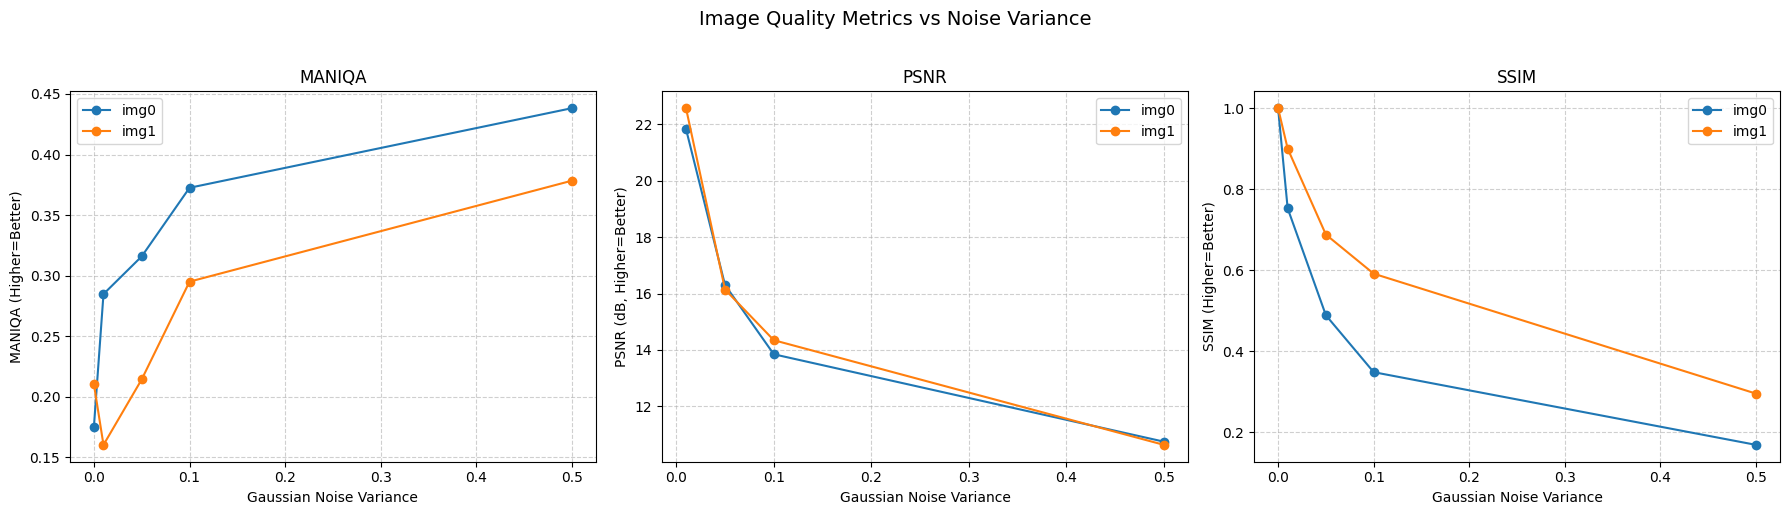

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pyiqa
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from torchvision import transforms

# Load MANIQA model
maniqa_model = pyiqa.create_metric('maniqa', device='cpu')

path = 'C:/Users/nunni/OneDrive/Skrivebord/Bachelor/Bachelor/'

# File lists
var = ['noisy0_0.jpg', 'noisy0_0.01.jpg', 'noisy0_0.05.jpg', 'noisy0_0.1.jpg', 'noisy0_0.5.jpg']
var1 = ['noisy1_0.jpg', 'noisy1_0.01.jpg', 'noisy1_0.05.jpg', 'noisy1_0.1.jpg', 'noisy1_0.5.jpg']

# Reference images
ref0 = cv2.cvtColor(cv2.imread(path + var[0]), cv2.COLOR_BGR2RGB)
ref1 = cv2.cvtColor(cv2.imread(path + var1[0]), cv2.COLOR_BGR2RGB)

results = []

resize = transforms.Resize((224, 224))

def evaluate_set(file_list, ref_img, img_id):
    for fname in file_list:
        noisy = cv2.cvtColor(cv2.imread(path + fname), cv2.COLOR_BGR2RGB)

        variance = float(fname.split("_")[-1].replace(".jpg", ""))

        # MANIQA (resize -> PIL -> score)
        noisy_pil = Image.fromarray(noisy)
        noisy_resized = resize(noisy_pil)
        m_score = maniqa_model(noisy_resized).item()

        # PSNR
        p_score = psnr(ref_img, noisy, data_range=255)

        # SSIM
        s_score = ssim(ref_img, noisy, channel_axis=-1, data_range=255)

        results.append({
            "Image": img_id,
            "Variance": variance,
            "MANIQA": m_score,
            "PSNR": p_score,
            "SSIM": s_score
        })

# Run evaluations
evaluate_set(var, ref0, "img0")
evaluate_set(var1, ref1, "img1")

# DataFrame
df_metrics = pd.DataFrame(results).sort_values(by=["Image", "Variance"])
print(df_metrics)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["MANIQA", "PSNR", "SSIM"]
ylabels = ["MANIQA (Higher=Better)", "PSNR (dB, Higher=Better)", "SSIM (Higher=Better)"]

for ax, metric, ylabel in zip(axes, metrics, ylabels):
    for img_id, group in df_metrics.groupby("Image"):
        ax.plot(group["Variance"], group[metric], marker="o", label=img_id)
    ax.set_title(metric)
    ax.set_xlabel("Gaussian Noise Variance")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend()

plt.suptitle("Image Quality Metrics vs Noise Variance", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("results.png", dpi=150)
plt.show()


In [24]:
import pyiqa
print(pyiqa.list_models())


['ahiq', 'arniqa', 'arniqa-clive', 'arniqa-csiq', 'arniqa-flive', 'arniqa-kadid', 'arniqa-koniq', 'arniqa-live', 'arniqa-spaq', 'arniqa-tid', 'brisque', 'ckdn', 'clipiqa', 'clipiqa+', 'clipiqa+_rn50_512', 'clipiqa+_vitL14_512', 'clipscore', 'cnniqa', 'cw_ssim', 'dbcnn', 'dists', 'entropy', 'fid', 'fsim', 'gmsd', 'hyperiqa', 'ilniqe', 'inception_score', 'laion_aes', 'liqe', 'liqe_mix', 'lpips', 'lpips-vgg', 'mad', 'maniqa', 'maniqa-kadid', 'maniqa-koniq', 'maniqa-pipal', 'ms_ssim', 'musiq', 'musiq-ava', 'musiq-koniq', 'musiq-paq2piq', 'musiq-spaq', 'nima', 'nima-koniq', 'nima-spaq', 'nima-vgg16-ava', 'niqe', 'nlpd', 'nrqm', 'paq2piq', 'pi', 'pieapp', 'psnr', 'psnry', 'qalign', 'ssim', 'ssimc', 'stlpips', 'stlpips-vgg', 'topiq_fr', 'topiq_fr-pipal', 'topiq_iaa', 'topiq_iaa_res50', 'topiq_nr', 'topiq_nr-face', 'topiq_nr-flive', 'topiq_nr-spaq', 'tres', 'tres-flive', 'tres-koniq', 'unique', 'uranker', 'vif', 'vsi', 'wadiqam_fr', 'wadiqam_nr']
